In [1]:
from typing import Dict

from scicite.compute_features import get_formulaic_features, get_agent_features

/home/dmitry/cit_func/lib/python3.8/site-packages/allennlp/service/predictors/__init__.py:22: FutureWarning: allennlp.service.predictors.* has been depreciated. Please use allennlp.predictors.*
  warnings.warn("allennlp.service.predictors.* has been depreciated. "
/home/dmitry/cit_func/lib/python3.8/site-packages/allennlp/service/predictors/predictor.py:5: FutureWarning: allennlp.service.predictors.* has been deprecated. Please use allennlp.predictors.*
  warnings.warn("allennlp.service.predictors.* has been deprecated."


In [2]:
FILE_TEST_TRUE = "scicite/data/acl-arc/test.jsonl"
FILE_DEV_TRUE = "scicite/data/acl-arc/dev.jsonl"
FILE_TRAIN_TRUE = "scicite/data/acl-arc/train.jsonl"

CLASSES = ['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future']

In [3]:
def compute_all_patterns_features(item: Dict):
    formulaic_features, fn_1, __ = get_formulaic_features(item['sents_before'][0], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['sents_before'][0], prefix='InCitSent:')
    fn_3, fn_4 = [], []
    
    formulaic_clause_features = formulaic_features
    agent_clause_features = agent_features
    if len(item['sents_before']) > 1:
        for cur_sentence in item['sents_before'][1:]:
            _formulaic_features, fn_3, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
            _agent_features, fn_4, _ = get_agent_features(cur_sentence, prefix='InClause:')
            formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                        _formulaic_features)]
            agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                    _agent_features)]
    for cur_sentence in item['sents_after']:
        _formulaic_features, _, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
        _agent_features, _, _ = get_agent_features(cur_sentence, prefix='InClause:')
        formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                    _formulaic_features)]
        agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                _agent_features)]
        

    x = formulaic_features + agent_features + formulaic_clause_features + agent_clause_features 
    y = CLASSES.index(item['intent'])
    feature_names = fn_1 + fn_2
    if fn_3:
        feature_names += fn_3 + fn_4 
    return x, y, feature_names

In [4]:
def create_data():
    X = []
    y = []

    with jsonlines.open(FILE_TEST_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            X.append(_x)
            y.append(_y)
    
    with jsonlines.open(FILE_DEV_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            X.append(_x)
            y.append(_y)
    
    with jsonlines.open(FILE_TRAIN_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            X.append(_x)
            y.append(_y)
    
    return np.array(X), np.array(y)

In [5]:
X, y = create_data()

In [6]:
X.shape

(1941, 112)

In [7]:
y.shape

(1941,)

In [8]:
with jsonlines.open(FILE_TRAIN_TRUE, 'r') as reader:
    for item in reader:
        _, _, feature_names = compute_all_patterns_features(item)
        break

In [9]:
#feature_names

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [11]:
clf = LogisticRegression(multi_class='multinomial')
scores = cross_val_score(clf, X, y, scoring='f1_macro', cv=5)

In [12]:
scores.mean()

0.4828052889281137

In [13]:
scores = cross_val_score(clf, X, y, scoring='f1_micro', cv=5)

In [14]:
scores.mean()

0.6234145177960936

In [15]:
clf.fit(X, y)

LogisticRegression(multi_class='multinomial')

In [16]:
coeffs = clf.coef_

By class:

      'Background': 997,
 
      'Uses': 364,
      
      'CompareOrContrast': 351,
      
      'Motivation': 88,
      
      'Extends': 72,
      
      'Future': 69    

In [17]:
CLASSES

['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future']

In [18]:
def get_cv_score_by_class(class_: str, metric: str = 'f1'):
    y_ = y == CLASSES.index(class_)
    clf = LogisticRegression(multi_class='multinomial')
    scores = cross_val_score(clf, X, y_, scoring=metric, cv=5)
    return scores.mean()

In [19]:
for cls in CLASSES:
    print(f"Class={cls}, F1={get_cv_score_by_class(cls)}\n")

Class=Background, F1=0.7261306355435259

Class=Uses, F1=0.4565809737046118

Class=CompareOrContrast, F1=0.26949236350631156

Class=Motivation, F1=0.4437678413540483

Class=Extends, F1=0.4432995532309033

Class=Future, F1=0.4645680332739156



In [20]:
for cls in CLASSES:
    print(f"Class={cls}, Precision={get_cv_score_by_class(cls, 'precision')}\n")

Class=Background, Precision=0.6748134880595462

Class=Uses, Precision=0.7746706805327495

Class=CompareOrContrast, Precision=0.6372750503710256

Class=Motivation, Precision=0.8011904761904762

Class=Extends, Precision=0.7314285714285714

Class=Future, Precision=0.8019480519480521



In [21]:
for cls in CLASSES:
    print(f"Class={cls}, Recall={get_cv_score_by_class(cls, 'recall')}\n")

Class=Background, Recall=0.7863618090452261

Class=Uses, Recall=0.3269786910197869

Class=CompareOrContrast, Recall=0.17106639839034204

Class=Motivation, Recall=0.31830065359477117

Class=Extends, Recall=0.31999999999999995

Class=Future, Recall=0.34835164835164834



Error matrix:

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
FILE_TEST_PRED = "[TEST]_pred_weights.jsonl"
FILE_TEST_PRED_ONLY_BERT = "pred_test_with_bert.jsonl"
FILE_TEST_TRUE = "scicite/data/acl-arc/test.jsonl"

FILE_DEV_PRED = "[DEV]_pred_weights.jsonl"
FILE_DEV_PRED_ONLY_BERT = "pred_dev_with_bert.jsonl"
FILE_DEV_TRUE = "scicite/data/acl-arc/dev.jsonl"

FILE_TRAIN_PRED = "[TRAIN]_pred_weights.jsonl"
FILE_TRAIN_PRED_ONLY_BERT = "pred_train_with_bert.jsonl"
FILE_TRAIN_TRUE = "scicite/data/acl-arc/train.jsonl"

In [30]:
def get_true_pred(true_file, pred_file):
    # true values
    true = dict()
    with jsonlines.open(true_file) as reader:
        for obj in reader:
            true[obj['citation_id']] = obj['intent']
    
    # true+pred values
    pairs = dict()
    with jsonlines.open(pred_file) as reader:
        for obj in reader:
            pairs[obj['citation_id']] = [true[obj['citation_id']], obj['prediction']]
    
    # encode
    y_true_pred = list(pairs.values())
    y = []
    for pair in y_true_pred:
        y.append([CLASSES.index(pair[0]), CLASSES.index(pair[1])])
    y = np.array(y)
    y_true = y[:, 0]
    y_pred = y[:, 1]
    
    return y_true, y_pred

In [33]:
y_true_test, y_pred_test = get_true_pred(FILE_TEST_TRUE, FILE_TEST_PRED)

In [35]:
y_true_dev, y_pred_dev = get_true_pred(FILE_DEV_TRUE, FILE_DEV_PRED)

In [37]:
y_true_train, y_pred_train = get_true_pred(FILE_TRAIN_TRUE, FILE_TRAIN_PRED)

In [48]:
y_true_all = np.concatenate((y_true_test, y_true_dev, y_true_train))
y_pred_all = np.concatenate((y_pred_test, y_pred_dev, y_pred_train))

In [49]:
error_matrix_all = confusion_matrix(y_true_all, y_pred_all)

In [34]:
error_matrix = confusion_matrix(y_true_test, y_pred_test)

***Only validation:***

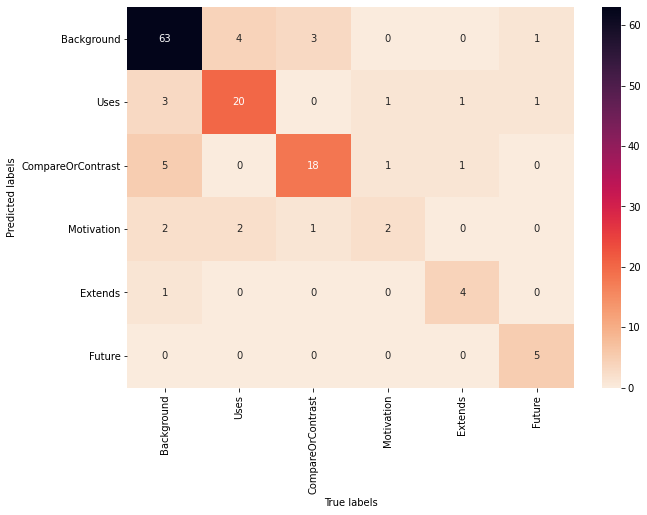

In [27]:
df_cm = pd.DataFrame(error_matrix, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (10,7))
cmap = sn.cm.rocket_r
sn.heatmap(df_cm, annot=True, cmap=cmap)

plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.show()

***All data:***

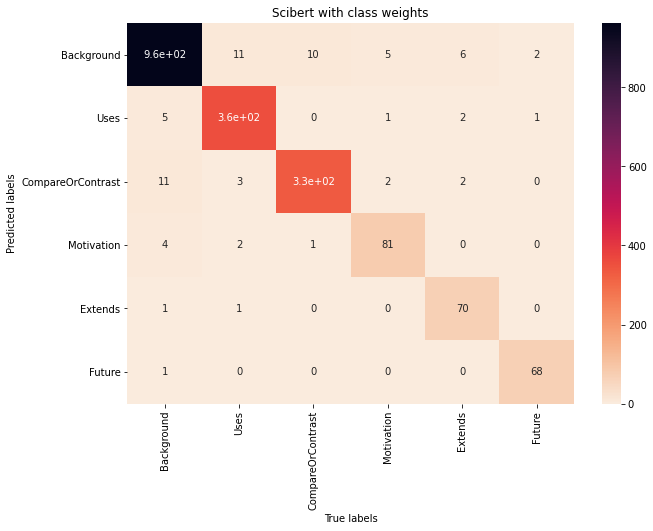

In [71]:
df_cm = pd.DataFrame(error_matrix_all, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (10,7))
cmap = sn.cm.rocket_r
sn.heatmap(df_cm, annot=True, cmap=cmap)

plt.title("Scibert with class weights")
plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.show()

only sciBERT

In [64]:
y_true_test_only, y_pred_test_only = get_true_pred(FILE_TEST_TRUE, FILE_TEST_PRED_ONLY_BERT)

In [65]:
y_true_dev_only, y_pred_dev_only = get_true_pred(FILE_DEV_TRUE, FILE_DEV_PRED_ONLY_BERT)

In [66]:
y_true_train_only, y_pred_train_only = get_true_pred(FILE_TRAIN_TRUE, FILE_TRAIN_PRED_ONLY_BERT)

In [67]:
y_true_all_only = np.concatenate((y_true_test_only, y_true_dev_only, y_true_train_only))
y_pred_all_only = np.concatenate((y_pred_test_only, y_pred_dev_only, y_pred_train_only))

In [72]:
error_matrix_test_all_only = confusion_matrix(y_true_test_only, y_true_test_only)

In [68]:
error_matrix_all_only = confusion_matrix(y_true_all_only, y_pred_all_only)

***All data***:

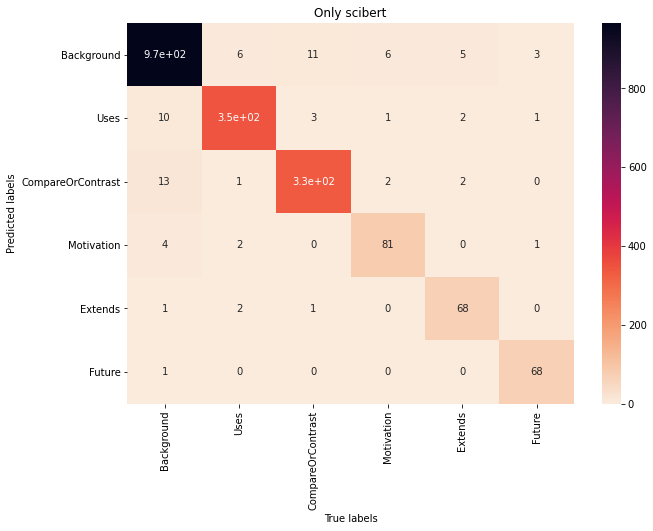

In [70]:
df_cm = pd.DataFrame(error_matrix_all_only, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (10,7))
cmap = sn.cm.rocket_r
sn.heatmap(df_cm, annot=True, cmap=cmap)

plt.title("Only scibert")
plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.show()